<a href="https://colab.research.google.com/gist/ThibauldC/fc5632b471296233b9c46a7426f68560/de_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data engineering
In this workshop we will the creation of a monitoring dashboard and an alert based on the real time data of the parking garages in Gent. We will perform the following steps:

1. Pull in the data from the Gent Open Data API.
2. Push relevant data as messages to RabbitMQ.
3. Push data from RabbitMQ to Prometheus (This will be done automagically).
4. Create dashboard based on parking garage data in Grafana.

In [ ]:
!pip install requests
!pip install pika
!pip install prometheus-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 5.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data from Gent Open Data API

The city of Gent is exposing an API containing free datasets [here](https://data.stad.gent/explore/?disjunctive.keyword&disjunctive.theme&sort=modified). There are different datasets, but we will be using the [real time bezetting parkeergarages](https://data.stad.gent/explore/dataset/bezetting-parkeergarages-real-time/table/?sort=-occupation) dataset because it is being updated minutely. To get the data you need to send a GET request to the correct API endpoint.

What you need to do is:

1. Send a GET request to the open data API endpoint for the parking garage occupancy rate -> You will receive a JSON response with several records (the parking garages and their occupancy rate). *Tip: you can nicely visualize your JSON [here](https://jsonformatter.curiousconcept.com/).*
2. Filter the records to only keep relevant data (parking name and occupancy rate) and re-collect the records in a list.

In [ ]:
import requests

garage_data = requests.get("https://data.stad.gent/api/records/1.0/search/?dataset=bezetting-parkeergarages-real-time")

if garage_data.status_code == 200:
    j = garage_data.json()
    parking_info = [{key: record["fields"].get(key) for key in ['name', 'availablecapacity']} for record in j.get("records")]
    print(parking_info)

[{'name': 'Ramen', 'availablecapacity': 114}, {'name': 'Ledeberg', 'availablecapacity': 427}, {'name': 'Vrijdagmarkt', 'availablecapacity': 78}, {'name': 'Savaanstraat', 'availablecapacity': 400}, {'name': 'Reep', 'availablecapacity': 237}, {'name': 'Sint-Pietersplein', 'availablecapacity': 404}, {'name': 'Tolhuis', 'availablecapacity': 60}, {'name': 'Sint-Michiels', 'availablecapacity': 78}, {'name': 'Getouw', 'availablecapacity': 344}, {'name': 'B-Park Gent Sint-Pieters', 'availablecapacity': 818}]


Now we will push to a message broker, in this case RabbitMQ.

What I want you to do is:

1. Create a connection to RabbitMQ using a blocking connection to our RabbitMQ cluster.
2. Add your group number to every parking record and publish each record individually to queue *ghent_parking_occupancy*.

In [ ]:
import json
import pika

GROUP_NO = '10'

with pika.BlockingConnection(pika.ConnectionParameters(
    '',
    credentials=pika.PlainCredentials('', ''))) as conn:
  channel = conn.channel()
  print(parking_info)
  channel.queue_declare(queue='ghent_parking_occupancy')
  for parking in parking_info:
    parking["group_no"] = GROUP_NO
    channel.basic_publish(exchange='',
                      routing_key='ghent_parking_occupancy',
                      body=json.dumps(parking))
print(f"{len(parking_info)} messages published to RabbitMQ")

[{'name': 'Ramen', 'availablecapacity': 114, 'group_no': '10'}, {'name': 'Ledeberg', 'availablecapacity': 427, 'group_no': '10'}, {'name': 'Vrijdagmarkt', 'availablecapacity': 78, 'group_no': '10'}, {'name': 'Savaanstraat', 'availablecapacity': 400, 'group_no': '10'}, {'name': 'Reep', 'availablecapacity': 237, 'group_no': '10'}, {'name': 'Sint-Pietersplein', 'availablecapacity': 404, 'group_no': '10'}, {'name': 'Tolhuis', 'availablecapacity': 60, 'group_no': '10'}, {'name': 'Sint-Michiels', 'availablecapacity': 78, 'group_no': '10'}, {'name': 'Getouw', 'availablecapacity': 344, 'group_no': '10'}, {'name': 'B-Park Gent Sint-Pieters', 'availablecapacity': 818, 'group_no': '10'}]
10 messages published to RabbitMQ


Now let's put it in a infinite loop to continuously pull occupancy data from our API and push the data to our message broker. It needs to be done once a minute.

In [ ]:
from datetime import datetime
import json
import time

import pika
from prometheus_client import CollectorRegistry, push_to_gateway, Gauge
import requests

GROUP_NO = '10'


while True:
  garage_data = requests.get("https://data.stad.gent/api/records/1.0/search/?dataset=bezetting-parkeergarages-real-time")

  if garage_data.status_code == 200:
      j = garage_data.json()
      parking_data = [{key: record["fields"].get(key) for key in ['name', 'availablecapacity']} for record in j.get("records")]
      print(parking_data)


  with pika.BlockingConnection(pika.ConnectionParameters(
    '',
    credentials=pika.PlainCredentials('', ''))) as conn:
      channel = conn.channel()
      channel.queue_declare(queue='ghent_parking_occupancy')
      for parking in parking_data:
        parking["group_no"] = GROUP_NO
        channel.basic_publish(exchange='',
                          routing_key='ghent_parking_occupancy',
                          body=json.dumps(parking))
  print("Message published to RabbitMQ")

  time.sleep(60)



## Dashboard in Grafana

Now let's create some sort of dashboard for this metric. Our data has been sent to **Prometheus** in the background, which is a monitoring tool where we can push metrics.

The occupancy data for each parking has been represented in a [Gauge metric](https://prometheus.io/docs/concepts/metric_types/#gauge).

To visualize and represent the data we will create a dashboard in **Grafana**, which is a tool that can be used for visualizing data and metrics.

You can find an example on how to query the gauge [here](https://tomgregory.com/how-and-when-to-use-a-prometheus-gauge/).

We will visualize the gauge metric in Grafana with the [Gauge visualization](https://grafana.com/docs/grafana/latest/panels-visualizations/visualizations/gauge/).

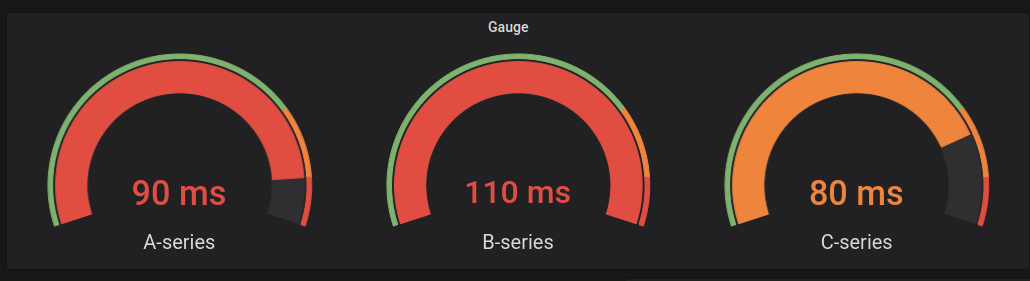

Here is the link tot Grafana: http://bydes.northeurope.cloudapp.azure.com/grafana


## Alerting

If you have time you can also create a [Grafana managed alert](https://grafana.com/docs/grafana/latest/alerting/alerting-rules/create-grafana-managed-rule/) which will be sent to the private Telegram channel . Invitation link [here](https://t.me/+W-NdV2a_RnIxMjI0). If you want to try this at home, you can find how to configure a Telegram bot to be used in Grafana [on this GitHub Gist](https://gist.github.com/ilap/cb6d512694c3e4f2427f85e4caec8ad7). This has already been configured.